# Introduction to Autoencoders

In [1]:
## All requirements for this notebook
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np


SEED = 5000
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [63]:
## We will be using popular MNIST dataset
train_data = torchvision.datasets.MNIST(root='MNIST-data', 
                                        transform=torchvision.transforms.ToTensor(),
                                        train=True,
                                        download=True
                                       )
test_data = torchvision.datasets.MNIST(root='MNIST-data', 
                                        transform=torchvision.transforms.ToTensor(),
                                        train=False
                                       )

In [66]:
def show_image_helper(image):
    image = image.view(28, 28)
    plt.imshow(image.cpu().detach(), cmap="gray")
    plt.show()
    print("Max Element: ", rdm_img.max())
    print("Min Element: ", rdm_img.min())

Shape of MNIST Dataset: torch.Size([60000, 28, 28])


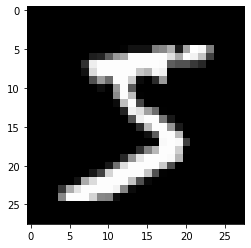

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Shape of Image: torch.Size([28, 28])


In [68]:
##What are we working with and what will we be doing
print(f"Shape of MNIST Dataset: {train_data.data.shape}")
rdm_img = train_data.data[np.random.randint(0,100)] / 255.0# get a random example
show_image_helper(rdm_img)
print(f"Shape of Image: {rdm_img.shape}")

In [69]:
# FURTHER SPLIT THE TRAINING INTO TRAINING AND VALIDATION
train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])

BATCH_SIZE = 512

# MAKE TRAINING DATALOADER
train_loader = torch.utils.data.DataLoader( # create a data loader
    train_data, # what dataset should it sample from?
    shuffle=True, # should it shuffle the examples?
    batch_size=BATCH_SIZE # how large should the batches that it samples be?
)

# MAKE VALIDATION DATALOADER
val_loader = torch.utils.data.DataLoader(
    val_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)

# MAKE TEST DATALOADER
test_loader = torch.utils.data.DataLoader(
    test_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.output_layer = nn.Linear(hidden_dims[-1], input_dim)
        self.hidden_layers = nn.ModuleList()
        for i in range(len(self.hidden_dims) -1):
            self.hidden_layers.append(nn.Linear(self.hidden_dims[i], self.hidden_dims[i+1]))
    
    def forward(self, x):
        x = self.input_layer(x)
        x = torch.relu(x)
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = torch.relu(x)
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x      

In [82]:
def train(model, epochs=10, learning_rate=0.001):
    model.train()
    optimiser = torch.optim.Adam(model.parameters(), lr = learning_rate)
    criterion = torch.nn.BCELoss()
    
    for epoch in range(epochs):
        total_loss = 0
        num_batches = 0
        for idx, batch in enumerate(train_loader):
            optimiser.zero_grad() ##zero out previous gradient map

            org_img, _ = batch ##don't need the label for Autoencoder training
            org_img = org_img.view(-1, 784).to(device) / 255.0
            org_img = org_img.double()
            gen_img = model(org_img)
            loss = criterion(gen_img.double(), org_img)
#             print(f"Epoch: {epoch}\tBatch: {idx}\tLoss: {loss}")
            total_loss += loss
            num_batches += 1
            loss.backward() ## backpropagate
            optimiser.step()
        average_loss = total_loss / num_batches
        print(f"Epoch {epoch}:\tScore: {1/average_loss}")

In [83]:
INPUT_DIM = 28*28
HIDDEN_DIM = [128, 32, 128]
EPOCHS = 50
LEARNING_RATE = 0.01

my_autoencoder = AutoEncoder(INPUT_DIM, HIDDEN_DIM).double().to(device)

In [ ]:
train(my_autoencoder, EPOCHS, LEARNING_RATE)

In [89]:
def validate(model, display_image=True):
    criterion = torch.nn.BCELoss()
    total_loss = 0
    num_batches = 0
    for val_img, _ in val_loader:
        val_img = val_img.to(device).double()
        val_img = val_img.view(-1, 784) / 255.0
        gen_img = model(val_img)
        if display_image:
            img_idx = np.random.randint(BATCH_SIZE)
            print("Generated Image")
            show_image_helper(gen_img[img_idx])
            print("Clean Image")
            show_image_helper(val_img[img_idx])
            print(1/criterion(gen_img.double(), val_img).item())
            return
        loss = criterion(gen_img.double(), val_img).item()
        total_loss += loss
        num_batches +=1
    average_loss = total_loss / num_batches
    return 1/average_loss.item()

Generated Image


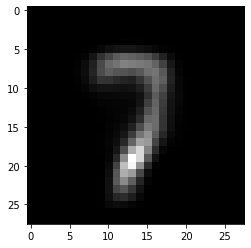

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Clean Image


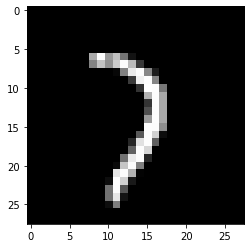

Max Element:  tensor(1.)
Min Element:  tensor(0.)
277.58220584483814


In [101]:
DISPLAY_IMAGES = True
score = validate(my_autoencoder, DISPLAY_IMAGES)
if not DISPLAY_IMAGES: print("Score: ", score)

# Application - Denoising an Image (CovNet)

In [104]:
def add_noise(clean_image, noise_factor):
    clean_image = clean_image.to(device)
    noisy_image = clean_image + noise_factor * torch.as_tensor(np.random.standard_normal(clean_image.shape), device=device)
    noisy_image = torch.clamp(noisy_image, 0.0, 1.0).double()
    return noisy_image

In [ ]:
class AutoEncoderCNN(nn.Module):
    def __init__(self, input_dim, filter_dims, kernel_sizes, stride = 2):
        super().__init__()
        self.input_layer = nn.Conv2d(1, 32, 5, 2)
        self.mid_input_later = nn.Conv2d(32, 64, 5, 2)
        self.mid_output_layer = nn.Conv2d(64, 32, 5, 2)
        self.output_layer = nn.Conv2d(32, 1, 5, 2)
        self.hidden_layers = nn.ModuleList()
    
    def forward(self, x):
        x = self.input_layer(x)
        x = torch.relu(x)
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = torch.relu(x)
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x   